# Covert Analysis

### Import essential libraries
Let's import matplotlib to perform plot operations and numpy to do calculations

In [1]:
import matplotlib.pyplot as plt
import numpy as np

Plot should capture and display as much details as possible. Therefore, we need to set the plot space wider.

In [17]:
plt.rcParams["figure.figsize"] = (20, 8)
props = dict(boxstyle='round', facecolor='#cccccc', alpha=0.5)

### Plot title parameters

In [13]:
CHANNEL = int(input("CHANNEL: ") or "25")
POWER_L = int(input("POWER: ") or "0")
RATE_P = int(input("RATE: ") or "50")
PACKETS = int(input("PACKETS: ") or "250")
SHW_PLT = bool(input("SHOW PLOT? ") or False)

ttl = 'RSSI Measurements {Total Packet Count: ' \
      + str(PACKETS) + '; Transmit Power: ' \
      + str(POWER_L) + ' dBm; Packet Rate: ' \
      + str(RATE_P) + ' ms; Channel: ' + str(int(CHANNEL)) + '}'

### Constants

In [15]:
MIN_RSSI = -100
MAX_RSSI = -10
BIN_PORTION = PACKETS / 10
BINS = [i * BIN_PORTION for i in range(11)]

L_WIDTH = 1

## Defining nodes

In this section, we define the addresses of transmitting nodes. Make sure they match with the output from `Contiki-ng` serial log output.

In [9]:
TX_NODE = '5b7f.b713.0074.1200'

### Extract packet data

This method will take a file of packet readings as input and go through each line. If any line has the IP address defined above, it will fill in the points array with the corresponding RSSI value and another array with sequence number

There will be two lists returned at last, with RSSI readings and sequence.

Sample readline will look like `[INFO: EavesDr   ] Received 0 from 0f2a.7d13.0074.1200 [RSSI: -60 | LQI: 107]`


In [10]:
def extract_packet_data(filename):
    file_node_lines = filename.readlines()
    node_points = []
    node_seq = []

    for line in file_node_lines:
        if TX_NODE in line:
            try:
                line_as_list = line.split(' ')
                rssi = int(line_as_list[-4])
                seq = int(line_as_list[-8])
                node_points.append(rssi)
                node_seq.append(seq)
            except:
                continue

    return node_points, node_seq

### Process packet data
Now we can open the log files with readings and process the data. There are usually 4 eavesdroppers and one in-body receiver in the picture. Therefore we will be parsing 5 files.

In [11]:
try:
    with open('Eaves-1.txt', 'r') as F:
        (P1_E1, S_P1_E1) = extract_packet_data(F)
except FileNotFoundError:
    print("File not found")

try:
    with open('Eaves-2.txt', 'r') as F:
        (P1_E2, S_P1_E2) = extract_packet_data(F)
except FileNotFoundError:
    print("File not found")

try:
    with open('Eaves-3.txt', 'r') as F:
        (P1_E3, S_P1_E3) = extract_packet_data(F)
except FileNotFoundError:
    print("File not found")

try:
    with open('Eaves-4.txt', 'r') as F:
        (P1_E4, S_P1_E4) = extract_packet_data(F)
except FileNotFoundError:
    print("File not found")

try:
    with open('Receive.txt', 'r') as F:
        (P1_P2, S_P1_P2) = extract_packet_data(F)
except FileNotFoundError:
    print("File not found")

Parsing Eaves-1.txt
Parsing Eaves-2.txt
Parsing Eaves-3.txt
Parsing Eaves-4.txt
Parsing Receive.txt


Combine the parsed data into two lists to plot.

In [30]:
PacketList = [P1_E1, P1_E2, P1_E3, P1_E4, P1_P2]
SequenceList = [S_P1_E1, S_P1_E2, S_P1_E3, S_P1_E4, S_P1_P2]

## Plot
We will plot two types of data graphs.

- Raw RSSI readings (in dBm) for each sequence point
- Reception ratio to identify if we received all the data points

However, in a sniffing mode where we do not have a sequence number, the second graph would not make a sense.

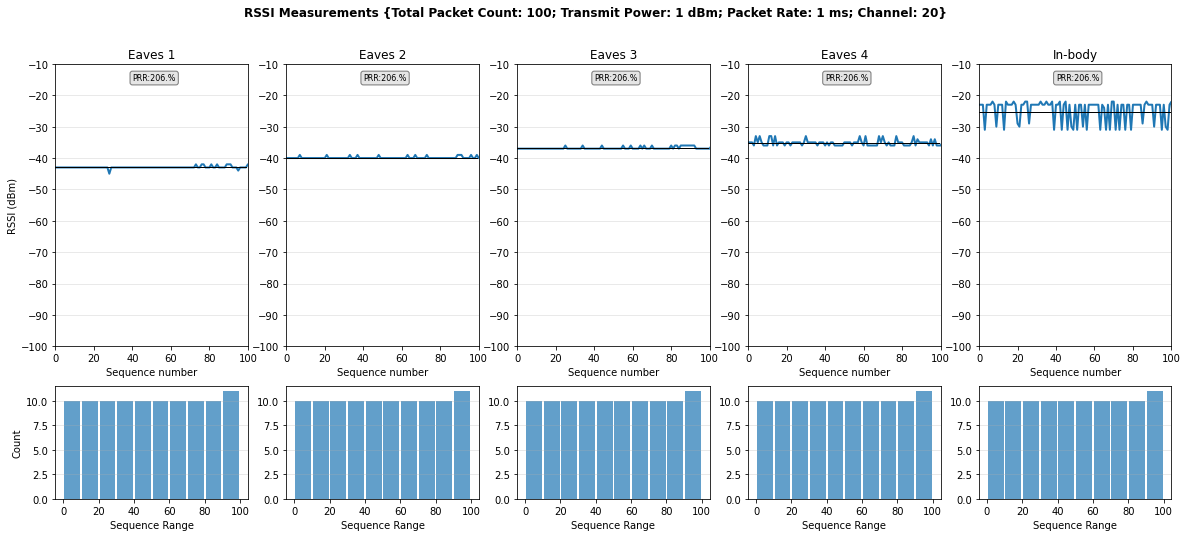

In [31]:
T_COUNT = 5
f_handle, ((e1, e2, e3, e4, r1), (f1, f2, f3, f4, f5)) = plt.subplots(2, T_COUNT, gridspec_kw={'height_ratios': [2.5, 1]})
f_handle.suptitle(ttl, fontweight='bold')

eAxes = [e1, e2, e3, e4, r1]
fAxes = [f1, f2, f3, f4, f5]

for f in range(T_COUNT):
    title = 'Eaves ' + str(f + 1)
    if f == 4: title = 'In-body'

    eAx = eAxes[f]
    prr = 'PRR:' + str(round((len(PacketList[f]) / PACKETS), 3) * 100)[:4] + '%'
    eAx.plot(SequenceList[f], PacketList[f], label='from transmitter', linewidth=L_WIDTH * 2)
    eAx.plot([np.mean(PacketList[f]) for _ in range(PACKETS)], label='rssi mean', linewidth=L_WIDTH, color=[0,0,0])
    eAx.set_xlim(0, PACKETS)
    eAx.set_ylim(MIN_RSSI, MAX_RSSI)
    eAx.set_title(title)
    eAx.set_xlabel('Sequence number')
    if f == 0: eAx.set_ylabel('RSSI (dBm)')
    eAx.text(0.4, 0.95, prr, transform=eAx.transAxes, fontsize=8, verticalalignment='center', bbox=props)
    eAx.grid(True, axis='y', alpha=0.35)

    fAxes[f].hist(SequenceList[f], BINS, label='count', alpha=0.7, rwidth=0.9)
    if f == 0: fAxes[f].set_ylabel("Count")
    fAxes[f].set_xlabel("Sequence Range")
    fAxes[f].grid(True, axis='y', alpha=0.35)

plt.savefig('results.png', dpi=300)

if SHW_PLT:
    plt.show()

In [28]:
NOTES = input("Notes: ")
with open("Notes.txt", 'a') as F:
    F.write(NOTES)